In [1]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre

# Step 1: Load the recording
local_path = '/media/server-benshalomlab/T9/Caren/MEASlices_02242025_PVSandCA/MEASlices_02122025_PVSandCA/250212/M07305/Network/000002/data.raw.h5'
recording = se.read_maxwell(local_path, stream_id='well002')

# Step 2: Bandpass filter the recording
freq_min = 300
freq_max = 4500
recording_bp = spre.bandpass_filter(recording, freq_min=freq_min, freq_max=freq_max)

# Step 3: Apply common median reference
recording_cmr = spre.common_reference(recording_bp, reference='global', operator='median')

# Step 4: Slice the recording (e.g., first 300 seconds)
fs = recording.get_sampling_frequency()
recording_chunk = recording_cmr.frame_slice(start_frame=0, end_frame=int(300 * fs))

print(f"Chunk duration: {recording_chunk.get_total_duration()} seconds")

Chunk duration: 300.0 seconds


In [2]:
# Step 5: Select specific channels
# For example, to select channels with IDs 10, 25, and 37 (you can adjust this list)
selected_channel_ids = [942, 966, 963, 959, 939, 898, 883, 871, 847, 843, 683, 863]    # replace with your desired channel IDs

# Convert selected_channel_ids to strings to match the channel_ids in recording_chunk
selected_channel_ids_str = [str(ch) for ch in selected_channel_ids]

# Slice the recording to keep only the selected channels
recording_chunk = recording_chunk.channel_slice(channel_ids=selected_channel_ids_str)

# Confirm selection
print(f"Selected channels: {recording_chunk.get_channel_ids()}")
print(f"New shape (channels x frames): {recording_chunk.get_num_channels()} x {recording_chunk.get_num_frames()}")


Selected channels: ['942' '966' '963' '959' '939' '898' '883' '871' '847' '843' '683' '863']
New shape (channels x frames): 12 x 3000000


In [3]:
# Step 1: Get channel IDs and locations
channel_ids = recording_chunk.get_channel_ids()
locations = recording_chunk.get_channel_locations()

# Step 2: Map electrodes based on locations
electrodes = []
channel_location_dict = {}
for channel, loc in zip(channel_ids, locations):
    electrode_id = 220 * int(loc[1] / 17.5) + int(loc[0] / 17.5)
    electrodes.append(electrode_id)
    channel_location_dict[channel] = electrode_id

print(f"Mapped {len(electrodes)} electrodes.")

Mapped 12 electrodes.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Define the channels to analyze
#channels_to_plot = [927, 934, 935, 938, 939, 942, 943, 947, 950, 951, 955, 959, 963, 
                    #966, 967, 971, 974, 975, 979, 983, 987, 991, 995, 
                    #998, 999, 1003, 1007, 1011, 1015]  # Replace with desired channel indices


fs = recording_chunk.get_sampling_frequency()

# Step 2: Extract traces for a specific time range
start_time = 0 # Start time in seconds
end_time = 300    # End time in seconds
traces = recording_chunk.get_traces(
    start_frame=int(start_time * fs),
    end_frame=int(end_time * fs),
    segment_index=0,
    return_scaled=True
)

# Step 3: Detect spikes using a standard deviation threshold
def detect_peaks_stddev(trace, peak_sign, std_multiplier):
    mean = np.mean(trace)
    std = np.std(trace)
    threshold = mean + std_multiplier * std if peak_sign == "pos" else mean - std_multiplier * std
    if peak_sign == "pos":
        peaks = np.where((trace[1:-1] > trace[:-2]) & (trace[1:-1] > trace[2:]) & (trace[1:-1] > threshold))[0] + 1
    elif peak_sign == "neg":
        peaks = np.where((trace[1:-1] < trace[:-2]) & (trace[1:-1] < trace[2:]) & (trace[1:-1] < threshold))[0] + 1
    else:
        raise ValueError("peak_sign must be 'pos' or 'neg'")
    return peaks, threshold

# Step 4: Analyze each channel
peak_sign = "neg"
std_multiplier = 6

# Filter channels_to_plot to include only valid indices
valid_channels_to_plot = [ch for ch in selected_channel_ids if ch < traces.shape[1]]

for channel_idx in selected_channel_ids:
    trace = traces[:, selected_channel_ids.index(channel_idx)]
    peaks, threshold = detect_peaks_stddev(trace, peak_sign, std_multiplier)
    print(f"Channel {selected_channel_ids.index(channel_idx)}: Detected {len(peaks)} spikes")

: 

In [6]:
import spikeinterface.sorters as ss

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


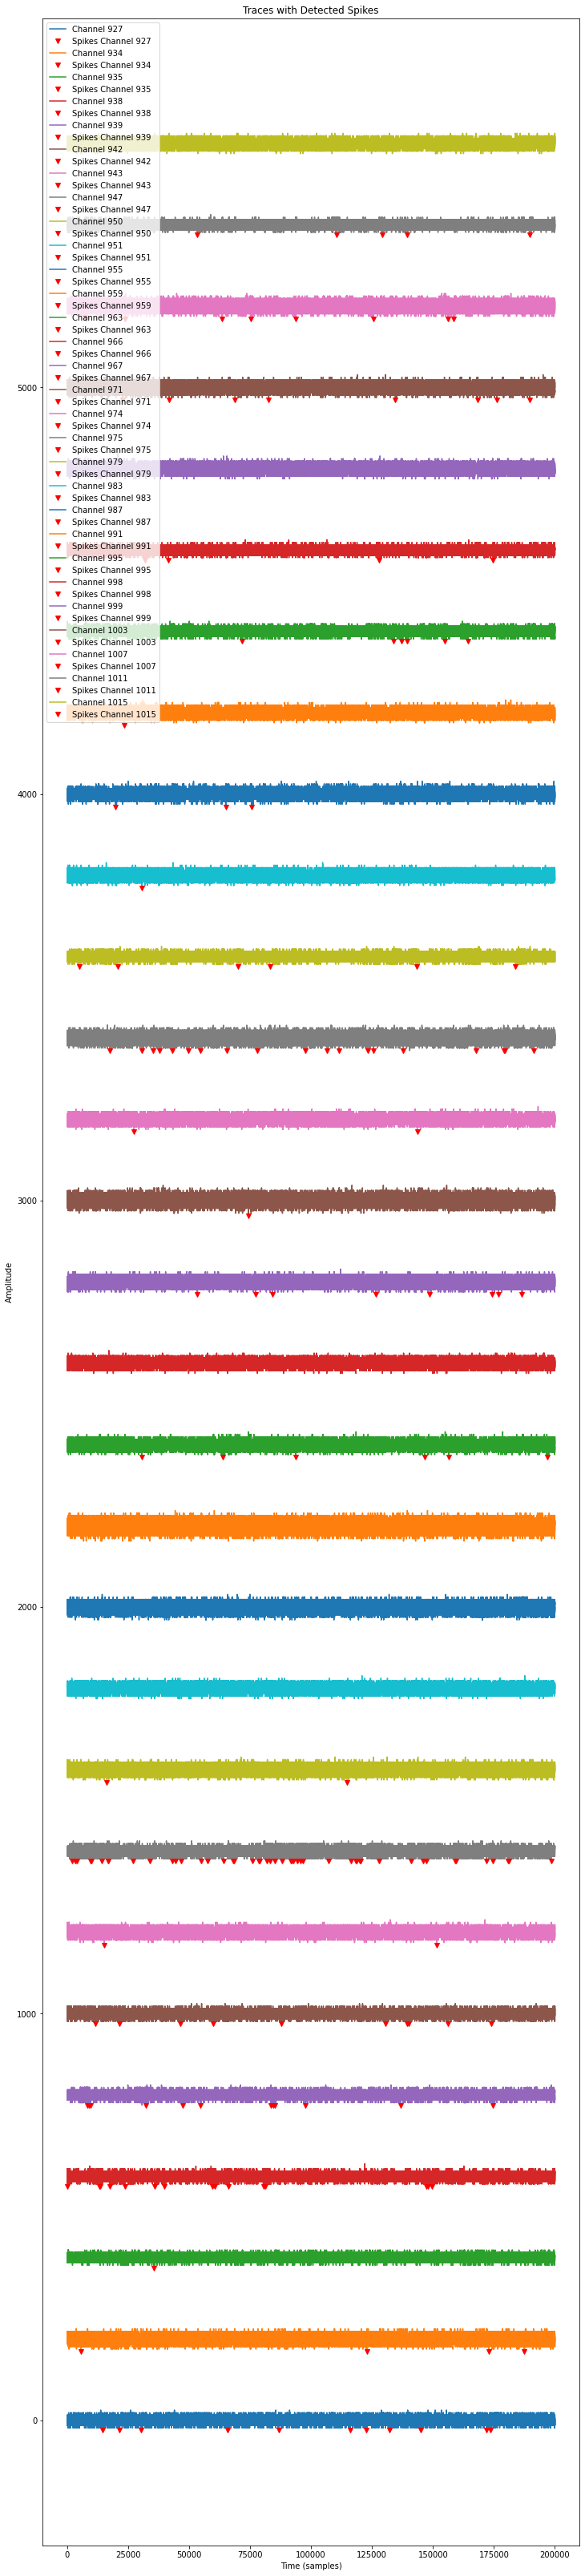

In [5]:
# Step 1: Filter channels_to_plot to include only valid channel indices
valid_channels_to_plot = [ch for ch in selected_channel_ids if ch < traces.shape[1]]
channel_idx = selected_channel_ids.index(channel_idx)
# Step 1: Plot traces with detected spikes
plt.figure(figsize=(12, len(selected_channel_ids) * 2))
for i, channel_idx in enumerate(selected_channel_ids):
    trace = traces[:, selected_channel_ids.index(channel_idx)]
    peaks, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)
    plt.plot(trace + i * 200, label=f"Channel {channel_idx}")
    plt.plot(peaks, trace[peaks] + i * 200, 'rv', label=f"Spikes Channel {channel_idx}")

plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Traces with Detected Spikes")
plt.legend()
plt.show()

In [7]:
# Step 1: Calculate firing rates for each channel
total_duration = recording_chunk.get_total_duration()
firing_rates = {}
for channel_idx in selected_channel_ids:
    # Map channel ID to its corresponding index in the traces array
    channel_index = selected_channel_ids.index(channel_idx)
    trace = traces[:, channel_index]
    peaks, _ = detect_peaks_stddev(trace, peak_sign, std_multiplier)
    firing_rate = len(peaks) / total_duration
    firing_rates[channel_idx] = firing_rate

# Step 2: Display firing rates
for channel_idx, rate in firing_rates.items():
    print(f"Channel {channel_idx}: Firing Rate = {rate:.2f} Hz")

Channel 927: Firing Rate = 0.04 Hz
Channel 934: Firing Rate = 0.01 Hz
Channel 935: Firing Rate = 0.00 Hz
Channel 938: Firing Rate = 0.05 Hz
Channel 939: Firing Rate = 0.04 Hz
Channel 942: Firing Rate = 0.03 Hz
Channel 943: Firing Rate = 0.01 Hz
Channel 947: Firing Rate = 0.16 Hz
Channel 950: Firing Rate = 0.01 Hz
Channel 951: Firing Rate = 0.00 Hz
Channel 955: Firing Rate = 0.00 Hz
Channel 959: Firing Rate = 0.00 Hz
Channel 963: Firing Rate = 0.02 Hz
Channel 966: Firing Rate = 0.00 Hz
Channel 967: Firing Rate = 0.03 Hz
Channel 971: Firing Rate = 0.00 Hz
Channel 974: Firing Rate = 0.01 Hz
Channel 975: Firing Rate = 0.06 Hz
Channel 979: Firing Rate = 0.02 Hz
Channel 983: Firing Rate = 0.00 Hz
Channel 987: Firing Rate = 0.01 Hz
Channel 991: Firing Rate = 0.00 Hz
Channel 995: Firing Rate = 0.02 Hz
Channel 998: Firing Rate = 0.01 Hz
Channel 999: Firing Rate = 0.00 Hz
Channel 1003: Firing Rate = 0.03 Hz
Channel 1007: Firing Rate = 0.03 Hz
Channel 1011: Firing Rate = 0.02 Hz
Channel 1015: Fir

In [44]:
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw

# Step 1: Select the specific channel (e.g., 972)
channel_id_to_sort = 927
recording_single_channel = recording_chunk.channel_slice(channel_ids=[str(channel_id_to_sort)])

# Step 2: Run spike sorting (e.g., using SpykingCircus)
sorting_output_folder = "spykingcircus_output"
sorting = ss.run_sorter('spykingcircus', recording_single_channel, output_folder=sorting_output_folder)

# Step 3: Plot the traces and detected spikes
# Extract traces for visualization
traces_single_channel = recording_single_channel.get_traces(return_scaled=True)

# Plot the traces
sw.plot_timeseries(recording_single_channel)

# Plot the spike trains
sw.plot_rasters(sorting)

/tmp/ipykernel_18112/1145391062.py:10: DeprecationWarning: `output_folder` is deprecated and will be removed in version 0.103.0 Please use folder instead
  sorting = ss.run_sorter('spykingcircus', recording_single_channel, output_folder=sorting_output_folder)


Exception: The sorter spykingcircus is not installed. Please install it with:

To use Spyking-Circus run:

        >>> pip install spyking-circus

        Need MPICH working, for ubuntu do:
            sudo apt install libmpich-dev mpich

        More information on Spyking-Circus at:
            https://spyking-circus.readthedocs.io/en/latest/
    

In [6]:
import spikeinterface.sorters as ss
import spikeinterface.qualitymetrics as qm
default_KS2_params = ss.get_default_sorter_params('kilosort2')
default_KS2_params['detect_threshold'] = 4# Adjust the detection threshold

default_KS2_params['minFR'] = 0 # Adjust the number of workers based on your system


print(default_KS2_params)

output_folder = '/mnt/disk15tb/mmpatil/MEA_Analysis_FEB25/IPNAnalysis/kilosort_output/'

run_sorter = ss.run_sorter('kilosort2',recording=recording_chunk, output_folder=output_folder, docker_image= 'mandarmp/benshalom:v1', verbose=True, remove_existing_folder = True, **default_KS2_params)

 

{'detect_threshold': 4, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'momentum': [20.0, 400.0], 'car': True, 'minFR': 0, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'lam': 10.0, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': ('matlab_files',), 'delete_recording_dat': False, 'n_jobs': 48, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}
installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing neo with pypi in container
Installing h5py with pypi in container
Running kilosort2 sorter inside mandarmp/benshalom:v1
Stopping container


SpikeSortingError: Spike sorting in docker failed with the following error:
write_binary_recording:   0%|          | 0/300 [00:00<?, ?it/s]write_binary_recording:   0%|          | 1/300 [00:10<53:54, 10.82s/it]write_binary_recording:  21%|██        | 62/300 [00:10<30:02,  7.57s/it]write_binary_recording:  25%|██▍       | 74/300 [00:15<20:26,  5.42s/it]write_binary_recording:  28%|██▊       | 84/300 [00:16<13:43,  3.81s/it]write_binary_recording:  33%|███▎      | 100/300 [00:16<08:54,  2.67s/it]write_binary_recording:  36%|███▌      | 108/300 [00:16<05:59,  1.87s/it]write_binary_recording:  39%|███▉      | 117/300 [00:19<04:15,  1.40s/it]write_binary_recording:  41%|████      | 123/300 [00:21<03:15,  1.10s/it]write_binary_recording:  42%|████▏     | 127/300 [00:22<02:21,  1.22it/s]write_binary_recording:  43%|████▎     | 130/300 [00:22<01:38,  1.72it/s]write_binary_recording:  52%|█████▏    | 156/300 [00:22<00:59,  2.44it/s]write_binary_recording:  55%|█████▌    | 165/300 [00:24<00:46,  2.88it/s]write_binary_recording:  57%|█████▋    | 170/300 [00:25<00:43,  2.99it/s]write_binary_recording:  58%|█████▊    | 174/300 [00:27<00:40,  3.09it/s]write_binary_recording:  59%|█████▉    | 177/300 [00:27<00:37,  3.27it/s]write_binary_recording:  63%|██████▎   | 188/300 [00:28<00:24,  4.57it/s]write_binary_recording:  64%|██████▍   | 192/300 [00:28<00:18,  5.99it/s]write_binary_recording:  66%|██████▌   | 197/300 [00:28<00:14,  6.93it/s]write_binary_recording:  71%|███████   | 212/300 [00:28<00:09,  9.53it/s]write_binary_recording:  72%|███████▏  | 216/300 [00:31<00:25,  3.35it/s]write_binary_recording:  73%|███████▎  | 219/300 [00:32<00:21,  3.75it/s]write_binary_recording:  74%|███████▍  | 222/300 [00:32<00:17,  4.52it/s]write_binary_recording:  76%|███████▌  | 228/300 [00:33<00:12,  5.81it/s]write_binary_recording:  80%|███████▉  | 239/300 [00:33<00:08,  7.11it/s]write_binary_recording:  81%|████████  | 243/300 [00:34<00:06,  8.67it/s]write_binary_recording:  85%|████████▌ | 255/300 [00:34<00:03, 11.38it/s]write_binary_recording:  86%|████████▌ | 258/300 [00:34<00:03, 10.62it/s]write_binary_recording:  87%|████████▋ | 260/300 [00:34<00:03, 12.07it/s]write_binary_recording:  87%|████████▋ | 262/300 [00:36<00:09,  3.90it/s]write_binary_recording:  88%|████████▊ | 264/300 [00:36<00:08,  4.42it/s]write_binary_recording:  89%|████████▊ | 266/300 [00:37<00:08,  4.09it/s]write_binary_recording:  89%|████████▉ | 268/300 [00:37<00:06,  4.58it/s]write_binary_recording:  90%|█████████ | 271/300 [00:37<00:04,  6.08it/s]write_binary_recording:  91%|█████████ | 273/300 [00:37<00:04,  6.12it/s]write_binary_recording:  96%|█████████▌| 288/300 [00:37<00:01,  8.56it/s]write_binary_recording: 100%|██████████| 300/300 [00:37<00:00,  7.90it/s]
RUNNING SHELL SCRIPT: /mnt/disk15tb/mmpatil/MEA_Analysis_FEB25/IPNAnalysis/kilosort_output/sorter_output/run_kilosort2.sh
Time   0s. Determining good channels.. 

found 3175 threshold crossings in 300.00 seconds of data 

found 0 bad channels 

Time   4s. Computing whitening matrix.. 

Getting channel whitening matrix... 

Channel-whitening matrix computed. 

Time   4s. Loading raw data and applying filters... 

Time   5s. Finished preprocessing 46 batches. 

random seed for clusterSingleBatches: 1

Obtained 7 PC waveforms in 0.19 seconds 

Batch 1 has fewer than Nfilt spikes.

Warning: data batch #1 only had 3 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

time 0.03, pre clustered 1 / 46 batches 

Batch 2 has fewer than Nfilt spikes.

Warning: data batch #2 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 3 has fewer than Nfilt spikes.

Warning: data batch #3 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 4 has fewer than Nfilt spikes.

Warning: data batch #4 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 5 has fewer than Nfilt spikes.

Warning: data batch #5 only had 3 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 6 has fewer than Nfilt spikes.

Warning: data batch #6 only had 2 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 7 has fewer than Nfilt spikes.

Warning: data batch #7 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 8 has fewer than Nfilt spikes.

Warning: data batch #8 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 9 has fewer than Nfilt spikes.

Warning: data batch #9 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 10 has fewer than Nfilt spikes.

Warning: data batch #10 only had 2 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 11 has fewer than Nfilt spikes.

Warning: data batch #11 only had 2 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 12 has fewer than Nfilt spikes.

Warning: data batch #12 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 13 has fewer than Nfilt spikes.

Warning: data batch #13 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 14 has fewer than Nfilt spikes.

Warning: data batch #14 only had 3 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 15 has fewer than Nfilt spikes.

Warning: data batch #15 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 16 has fewer than Nfilt spikes.

Warning: data batch #16 only had 2 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 17 has fewer than Nfilt spikes.

Warning: data batch #17 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 18 has fewer than Nfilt spikes.

Warning: data batch #18 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 19 has fewer than Nfilt spikes.

Warning: data batch #19 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 20 has fewer than Nfilt spikes.

Warning: data batch #20 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 21 has fewer than Nfilt spikes.

Warning: data batch #21 only had 2 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 22 has fewer than Nfilt spikes.

Warning: data batch #22 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 23 has fewer than Nfilt spikes.

Warning: data batch #23 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 24 has fewer than Nfilt spikes.

Warning: data batch #24 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 25 has fewer than Nfilt spikes.

Warning: data batch #25 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 26 has fewer than Nfilt spikes.

Warning: data batch #26 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 27 has fewer than Nfilt spikes.

Warning: data batch #27 only had 2 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 28 has fewer than Nfilt spikes.

Warning: data batch #28 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 29 has fewer than Nfilt spikes.

Warning: data batch #29 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 30 has fewer than Nfilt spikes.

Warning: data batch #30 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 31 has fewer than Nfilt spikes.

Warning: data batch #31 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 32 has fewer than Nfilt spikes.

Warning: data batch #32 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 33 has fewer than Nfilt spikes.

Warning: data batch #33 only had 2 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 34 has fewer than Nfilt spikes.

Warning: data batch #34 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 35 has fewer than Nfilt spikes.

Warning: data batch #35 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 36 has fewer than Nfilt spikes.

Warning: data batch #36 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 37 has fewer than Nfilt spikes.

Warning: data batch #37 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 38 has fewer than Nfilt spikes.

Warning: data batch #38 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 39 has fewer than Nfilt spikes.

Warning: data batch #39 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 40 has fewer than Nfilt spikes.

Warning: data batch #40 only had 0 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 41 has fewer than Nfilt spikes.

Warning: data batch #41 only had 2 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 42 has fewer than Nfilt spikes.

Warning: data batch #42 only had 3 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 43 has fewer than Nfilt spikes.

Warning: data batch #43 only had 2 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 44 has fewer than Nfilt spikes.

Warning: data batch #44 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 45 has fewer than Nfilt spikes.

Warning: data batch #45 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

Batch 46 has fewer than Nfilt spikes.

Warning: data batch #46 only had 1 spikes 



> In clusterSingleBatches (line 121)

In kilosort2_master (line 23)

----------------------------------------Unrecognized function or variable 'W'.
Error running kilosort2
Traceback (most recent call last):
  File "/mnt/disk15tb/mmpatil/MEA_Analysis_FEB25/IPNAnalysis/in_container_sorter_script.py", line 23, in <module>
    sorting = run_sorter_local(
  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/runsorter.py", line 225, in run_sorter_local
    SorterClass.run_from_folder(output_folder, raise_error, verbose)
  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/basesorter.py", line 292, in run_from_folder
    raise SpikeSortingError(
spikeinterface.sorters.utils.misc.SpikeSortingError: Spike sorting error trace:
Traceback (most recent call last):
  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/basesorter.py", line 257, in run_from_folder
    SorterClass._run_from_folder(sorter_output_folder, sorter_params, verbose)
  File "/home/miniconda3/lib/python3.8/site-packages/spikeinterface/sorters/external/kilosortbase.py", line 217, in _run_from_folder
    raise Exception(f"{cls.sorter_name} returned a non-zero exit code")
Exception: kilosort2 returned a non-zero exit code

Spike sorting failed. You can inspect the runtime trace in /mnt/disk15tb/mmpatil/MEA_Analysis_FEB25/IPNAnalysis/kilosort_output/spikeinterface_log.json.


In [ ]:

sortingKS3 = run_sorter.remove_empty_units()

sortingKS3 = ss.curation.remove_excess_spikes(sortingKS3,recording_chunk)

 

waveform_output_folder = 'waveform_output_05272025'

job_kwargs = dict(n_jobs=32, chunk_duration="1s", progress_bar=True)

waveforms = si.extract_waveforms(recording_chunk,sortingKS3,folder=waveform_output_folder,overwrite=True,**job_kwargs)

 

import spikeinterface.postprocessing as sp

 

sp.compute_spike_amplitudes(waveforms,load_if_exists=True,**job_kwargs)

metrics = qm.compute_quality_metrics(waveforms,load_if_exists=False,**job_kwargs)
